In [30]:
from tensorflow.keras import datasets, layers, models

import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [56]:
def padImage(image, pixels=5):
    bottom = image[-pixels:]
    top = image[:pixels]

    img = np.insert(image, 0, bottom, 0)
    img = np.insert(img, len(img), top, 0)
    #img = np.insert(img, [0], [0] * pixels, 1)
    #img = np.insert(img, [-1], [0] * pixels, 1)
    return img

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = (train_images / 255.0).astype(np.float32), test_images.astype(np.float32) / 255.0

In [57]:
### THE PAD HAS TO BE DONE IN THE
### POLAR SPACE

# 20 is the ceiling of (14 * sqrt(2))
X_train_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in train_images]
X_train_polar = [padImage(x, pixels=5) for x in X_train_polar]
X_train_polar = np.array(X_train_polar)[...,None]

X_test_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in test_images]
X_test_polar = [padImage(x, pixels=5) for x in X_test_polar]
X_test_polar = np.array(X_test_polar)[...,None]

# Rotate test set
X_test_r_polar = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in test_images]
X_test_r_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in X_test_r_polar]
X_test_r_polar = [padImage(x, pixels=5) for x in X_test_r_polar]
X_test_r_polar = np.array(X_test_r_polar)[...,None]

In [58]:
model = models.Sequential()
model.add(layers.Input(shape=X_train_polar.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [59]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 36, 26, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 3, 128)         73856     
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In [62]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_polar, train_labels, batch_size=32, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0497 - accuracy: 0.9844
Epoch 2/3
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0345 - accuracy: 0.9890
Epoch 3/3
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0278 - accuracy: 0.9911


In [63]:
model.evaluate(X_test_polar, test_labels, verbose=2)


# Plain accuracy
#accuracy = np.mean(model.predict(X_test_polar).argmax(axis=1) == test_labels)*100
# "Rotated" accuracy
#accuracy_rotated = np.mean(model.predict(X_test_r_polar).argmax(axis=1) == test_labels)*100

#print(accuracy, accuracy_rotated)

313/313 - 1s - loss: 0.0772 - accuracy: 0.9787


[0.07724881917238235, 0.9786999821662903]

In [64]:
model.evaluate(X_test_r_polar, test_labels, verbose=2)

313/313 - 1s - loss: 0.5868 - accuracy: 0.8447


[0.5867724418640137, 0.8446999788284302]

In [37]:
def polarImg(img):
    polarImage = cv.linearPolar(img, tuple(np.array(img.shape)/2), 20, cv.WARP_FILL_OUTLIERS)
    return polarImage

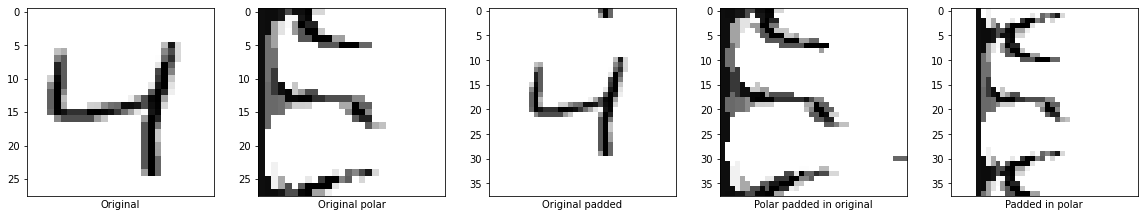

In [55]:
plt.figure(figsize=(20,20))

pic = train_images[2]
padding = 5

plt.subplot(5,5,1)
plt.xticks([])
plt.grid(False)
plt.xlabel('Original')
plt.imshow(pic, cmap=plt.cm.binary)

plt.subplot(5,5,2)
plt.xticks([])
plt.grid(False)
plt.xlabel('Original polar')
plt.imshow(polarImg(pic), cmap=plt.cm.binary)

plt.subplot(5,5,3)
plt.xticks([])
plt.grid(False)
plt.xlabel('Original padded')
plt.imshow(padImage(pic, padding), cmap=plt.cm.binary)

plt.subplot(5,5,4)
plt.xticks([])
plt.grid(False)
plt.xlabel('Polar padded in original')
plt.imshow(polarImg(padImage(pic, padding)), cmap=plt.cm.binary)

plt.subplot(5,5,5)
plt.xticks([])
plt.grid(False)
plt.xlabel('Padded in polar')
plt.imshow(padImage(polarImg(pic), padding), cmap=plt.cm.binary)